<a href="https://colab.research.google.com/github/afhabibieee/SMS-spam-or-ham/blob/main/sms_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries

In [ ]:
# Download All Dependencies
!pip install -q kaggle

# updating (server 1.5.12 / client 1.5.4)
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=714a675d9aba30efcc13ab7996432283b157db5c1a6ba0e705e2257cb76c2885
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


## Data Collection

In [ ]:
# Upload API Files from Kaggle
from google.colab import files
files.upload()

In [ ]:
# Connect Collab to Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
# Searching spam datasets
! kaggle datasets list -s spam

ref                                                  title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  ---------  ---------------  
veleon/ham-and-spam-dataset                          Email Spam                                12MB  2019-01-20 16:43:20           5025        109  0.75             
uciml/sms-spam-collection-dataset                    SMS Spam Collection Dataset              211KB  2016-12-02 19:29:17          87047        942  0.7352941        
ozlerhakan/spam-or-not-spam-dataset                  Spam or Not Spam Dataset                   1MB  2018-12-14 18:32:01           3896         34  0.88235295       
venky73/spam-mails-dataset                           Spam Mails Dataset                         2MB  2019-01-23 13:44:37           8607         60  0.7941176        
team

In [ ]:
# download dataset sms-spam from shravan3273
!kaggle datasets download "shravan3273/sms-spam"

  0% 0.00/207k [00:00<?, ?B/s]
100% 207k/207k [00:00<00:00, 7.88MB/s]


In [ ]:
# unzip spam dataset
!unzip sms-spam.zip

Archive:  sms-spam.zip
  inflating: spamraw.csv             


## Data Preprocessing

In [ ]:
# create pandas dataframe
import pandas as pd
data = pd.read_csv('spamraw.csv')
data

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...
...,...,...
5554,ham,You are a great role model. You are giving so ...
5555,ham,"Awesome, I remember the last time we got someb..."
5556,spam,"If you don't, your prize will go to another cu..."
5557,spam,"SMS. ac JSco: Energy is high, but u may not kn..."


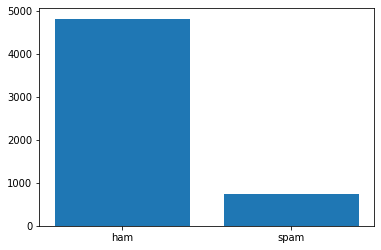

In [ ]:
import matplotlib.pyplot as plt
plt.bar(
    ['ham', 'spam'],
    data['type'].value_counts()
)
plt.show()

In [ ]:
data['type'].value_counts(normalize = True)

ham     0.865623
spam    0.134377
Name: type, dtype: float64

> As we can see that the data isn't balanced.

> There are 86% of the total data is ham. From this article ([How I handled imbalanced text data](https://towardsdatascience.com/how-i-handled-imbalanced-text-data-ba9b757ab1d8#:~:text=The%20simplest%20way%20to%20fix,synthetic%20instances%20from%20minority%20class.)) it says that accuracy is a sham in case of unbalanced data sets.

> So I decided to oversampling or undersampling this data using training data (using training data to avoid data leakage).

In [ ]:
# feature and target
X = data['text'].values
y = data['type'].values

In [ ]:
# split data training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Tokenizing, sequencing and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(5000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequences_train)
padded_test = pad_sequences(sequences_test)

In [ ]:
# Oversampling
import numpy as np
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(padded_train, y_train)

# distribution of data after resampling
np.unique(y_ros, return_counts=True)

(array(['ham', 'spam'], dtype=object), array([3860, 3860]))

Now, the data for the two classes is balanced

In [ ]:
# Undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(padded_train, y_train)

# distribution of data after resampling
np.unique(y_rus, return_counts=True)

(array(['ham', 'spam'], dtype=object), array([587, 587]))

This data when undersampling is certainly less. but let's see the result once it is fed to the model.

In [ ]:
# one-hot coding on each re-sampled data target

# at target oversampled
y_ros = pd.get_dummies(y_ros).values

# at target undersampled
y_rus = pd.get_dummies(y_rus).values

In [ ]:
# one-hot coding on test/validate data target
y_test = pd.get_dummies(y_test).values

## Modeling

In [ ]:
# import required libraries/modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
input_dim = padded_train.max() + 1
input_dim

5000

In [ ]:
# build archi model
def model():
  m = Sequential([
                  Embedding(input_dim=input_dim, output_dim=16),
                  LSTM(64),
                  Dense(128, activation='relu'),
                  Dense(64, activation='relu'),
                  Dense(2, activation='softmax')
  ])
  
  # compile model
  m.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  return m

### Train the model with the OVER-SAMPLED training data

In [ ]:
## add callback when model is trained
#from tensorflow.keras.callbacks import Callback
#
#class myCallback(Callback):
#  def on_epoch_end(self, epoch, logs={}):
#    if(logs.get('val_accuracy')>0.98):
#      print("\nAccuracy on validation data is more than 99% has been met")
#      self.model.stop_training = True
#callbacks = myCallback()

In [ ]:
"""
  Instead of using a stop callback at a certain threshold (from the cell above), 
  I prefer to use early stopping because the training accuracy and validation 
  are already very high (overfitting prevention)
"""
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=1
)

In [ ]:
model_ros = model()
num_epochs = 10

history_ros = model_ros.fit(
    X_ros, y_ros, 
    validation_data=(padded_test, y_test),
    epochs=num_epochs,
    verbose=2,
    callbacks=[early_stopping],
    use_multiprocessing=True
)

Epoch 1/10
242/242 - 24s - loss: 0.1338 - accuracy: 0.9526 - val_loss: 0.0619 - val_accuracy: 0.9838 - 24s/epoch - 98ms/step
Epoch 2/10
242/242 - 21s - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.1227 - val_accuracy: 0.9847 - 21s/epoch - 88ms/step
Epoch 3/10
242/242 - 21s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0847 - val_accuracy: 0.9865 - 21s/epoch - 88ms/step
Epoch 4/10
242/242 - 21s - loss: 2.7526e-04 - accuracy: 1.0000 - val_loss: 0.1134 - val_accuracy: 0.9838 - 21s/epoch - 88ms/step


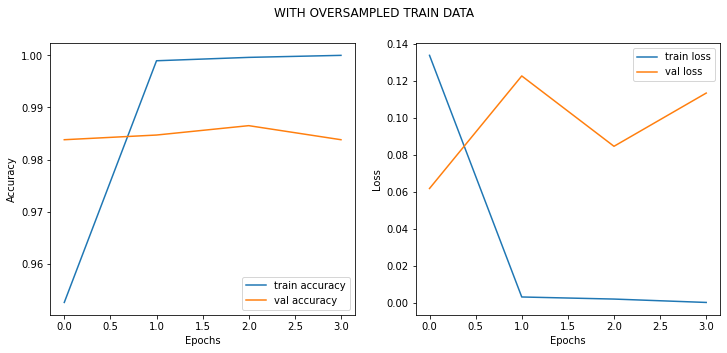

In [ ]:
# ploting accuracy and loss

fig, axs = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('WITH OVERSAMPLED TRAIN DATA')
axs[0].plot(history_ros.history['accuracy'], label='train accuracy')
axs[0].plot(history_ros.history['val_accuracy'], label='val accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[1].plot(history_ros.history['loss'], label='train loss')
axs[1].plot(history_ros.history['val_loss'], label='val loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')
axs[0].legend()
axs[1].legend()
fig.show()

In [ ]:
# test data evaluation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = model_ros.predict(padded_test)
print(classification_report(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1)
))

print('\n')

print(confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1)
))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       952
           1       0.98      0.91      0.94       160

    accuracy                           0.98      1112
   macro avg       0.98      0.95      0.97      1112
weighted avg       0.98      0.98      0.98      1112



[[949   3]
 [ 15 145]]


### Train the model with the UNDER-SAMPLED training data

In [ ]:
model_rus = model()
num_epochs = 10

history_rus = model_rus.fit(
    X_rus, y_rus, 
    validation_data=(padded_test, y_test),
    epochs=num_epochs,
    verbose=2,
    callbacks=[early_stopping],
    use_multiprocessing=True
)

Epoch 1/10
37/37 - 6s - loss: 0.5635 - accuracy: 0.7853 - val_loss: 0.4037 - val_accuracy: 0.8183 - 6s/epoch - 157ms/step
Epoch 2/10
37/37 - 3s - loss: 0.1709 - accuracy: 0.9446 - val_loss: 0.0917 - val_accuracy: 0.9802 - 3s/epoch - 94ms/step
Epoch 3/10
37/37 - 3s - loss: 0.0572 - accuracy: 0.9813 - val_loss: 0.0553 - val_accuracy: 0.9829 - 3s/epoch - 94ms/step
Epoch 4/10
37/37 - 3s - loss: 0.0262 - accuracy: 0.9932 - val_loss: 0.1128 - val_accuracy: 0.9631 - 3s/epoch - 94ms/step


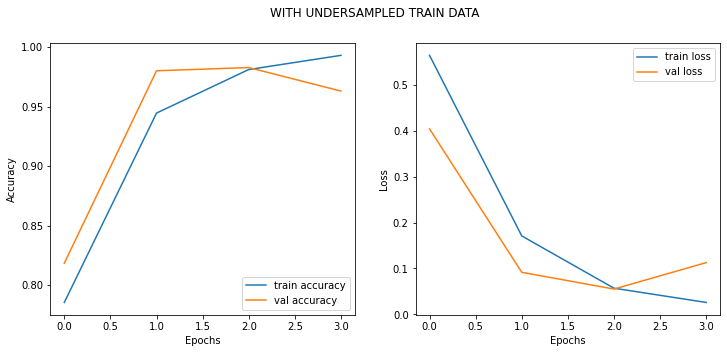

In [ ]:
# ploting accuracy and loss

fig, axs = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('WITH UNDERSAMPLED TRAIN DATA')
axs[0].plot(history_rus.history['accuracy'], label='train accuracy')
axs[0].plot(history_rus.history['val_accuracy'], label='val accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[1].plot(history_rus.history['loss'], label='train loss')
axs[1].plot(history_rus.history['val_loss'], label='val loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')
axs[0].legend()
axs[1].legend()
fig.show()

In [ ]:
# test data evaluation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = model_rus.predict(padded_test)
print(classification_report(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1)
))

print('\n')

print(confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1)
))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       952
           1       0.81      0.96      0.88       160

    accuracy                           0.96      1112
   macro avg       0.90      0.96      0.93      1112
weighted avg       0.97      0.96      0.96      1112



[[917  35]
 [  6 154]]
